In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch_geometric.data import Data

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Data sources.
data_root = '../data'
data_timeseries = '../data/raw_ts'
data_phenotype = '../data/phenotype.csv'
data_ct = '../data/CT.csv'
data_euler = '../data/Euler.csv'
data_computed_fcms = '../data/processed_ts'

In [3]:
def get_subject_ids(num_subjects=None, randomise=True, seed=0):
    subject_ids = np.load(os.path.join(data_root, 'subject_ids.npy'))

    if not num_subjects:
        return subject_ids

    if randomise:
        return np.random.choice(subject_ids, num_subjects, replace=False)
    else:
        return subject_ids[:num_subjects]

def get_stratified_subject_split(features, labels, test_size=0.1, random_state=0):
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    for train_validate_index, test_index in train_test_split.split(features, labels):
        features_train = features[train_validate_index]
        labels_train = labels[train_validate_index]

        train_validate_index = np.array(train_validate_index)
        test_index = np.array(test_index)

        train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)
        for train_index, validate_index in train_validate_split.split(features_train, labels_train):
            train_idx = train_validate_index[train_index]
            validate_idx = train_validate_index[validate_index]
            test_idx = test_index

            assert (len(np.intersect1d(train_idx, validate_idx)) == 0)
            assert (len(np.intersect1d(train_idx, test_idx)) == 0)
            assert (len(np.intersect1d(validate_idx, test_idx)) == 0)
            return train_idx, validate_idx, test_idx

def extract_phenotypes(uid_list, subject_ids):
    uid_list.append('eid')
    phenotype = pd.read_csv(data_phenotype, sep=',')
    subject_ids_no_UKB = [int(i[3:]) for i in subject_ids]

    # Extract data for relevant subject IDs.
    subject_phenotype = phenotype[phenotype['eid'].isin(subject_ids_no_UKB)]

    if len(subject_phenotype) != len(subject_ids):
        print('{} entries had phenotypic data missing.'.format(len(subject_ids) - len(subject_phenotype)))

    # Extract relevant UIDs.
    subject_phenotype = subject_phenotype[uid_list]

    # Add UKB prefix back to the index.
    subject_phenotype.index = ['UKB' + str(eid) for eid in subject_phenotype['eid']]

    return subject_phenotype

In [4]:
phenotype = pd.read_csv(data_phenotype, sep=',')
phenotype.index = np.vectorize(lambda x: 'UKB' + str(x))(phenotype['eid'])

/home/ks830/miniconda3/envs/brain/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (515,516,517,519) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
X = phenotype.drop('21003-2.0', axis=1)
y = phenotype['21003-2.0']

In [8]:
y

UKB1000028    57
UKB1000133    70
UKB1000260    68
UKB1000329    68
UKB1000430    64
              ..
UKB6025704    60
UKB6025720    57
UKB6025771    64
UKB6025805    63
UKB6025942    47
Name: 21003-2.0, Length: 19891, dtype: int64

In [10]:
phenotype_ids = phenotype[phenotype['21003-2.0'] > 45]['eid'].to_numpy()

In [11]:
phenotype_ids = np.vectorize(lambda x: 'UKB' + str(x))(phenotype_ids)

In [12]:
X.loc[phenotype_ids]

,Unnamed: 0,31-0.0,34-0.0,50-0.0,50-1.0,50-2.0,52-0.0,54-0.0,54-1.0,54-2.0,...,40006-23.0,40006-24.0,40006-25.0,40006-26.0,40006-27.0,40006-28.0,40006-29.0,40006-30.0,40006-31.0,eid
UKB1000028,1,Female,1958,170.0,169.0,170.0,9,11010,11024.0,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000028
UKB1000133,2,Male,1947,176.0,NaN,175.0,4,11010,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000133
UKB1000260,3,Female,1949,169.0,NaN,168.0,12,11004,NaN,11027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000260
UKB1000329,4,Female,1949,158.0,NaN,158.0,2,10003,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000329
UKB1000430,5,Female,1953,158.0,NaN,158.0,7,11009,NaN,11027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKB6025704,19887,Male,1954,180.0,180.0,180.0,7,11016,11024.0,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025704
UKB6025720,19888,Female,1958,165.0,NaN,165.0,12,11014,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025720
UKB6025771,19889,Female,1953,170.0,NaN,170.0,1,11013,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025771
UKB6025805,19890,Female,1951,165.0,NaN,164.0,12,11016,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025805


In [13]:
train_idx, _, _ = get_stratified_subject_split(X.loc[phenotype_ids].to_numpy(), y.loc[phenotype_ids].to_numpy())

In [14]:
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
phenotype_train = phenotype.iloc[train_idx]

In [15]:
y_train.value_counts()

67    826
68    788
66    785
69    771
65    752
64    720
70    707
61    690
62    665
63    647
60    603
59    584
71    578
58    550
57    527
55    524
56    518
53    500
72    484
52    480
54    479
73    467
51    434
50    396
74    324
49    292
75    269
48    215
76    206
77    103
47    101
78     69
46     23
79     21
80      4
45      3
44      1
Name: 21003-2.0, dtype: int64

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16106 entries, UKB5654063 to UKB1435289
Columns: 541 entries, Unnamed: 0 to eid
dtypes: float64(520), int64(9), object(12)
memory usage: 66.6+ MB


## Possibly interesting additional phenotypes for graph construction
```
54 UKB assessment centre
845 age completed full time education
10895 light smokers (pilot)
2644 light smokers
2887 number of cigarettes previously smoked daily
4548 health satisfaction
4581 financial situation satisfaction
6156 manic/hyper symptoms
20002 non-cancer illness code

20016 fluid intelligence score
20191 fluid intelligence score

20018 prospective memory result

20116 smoking status

20122 bipolar disorder status
20127 neuroticism score

87 non-cancer illness year
84 cancer year

20544 mental health problems ever diagnosed by a professional
```

**Prospective memory result**

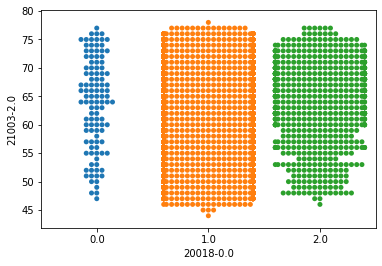

In [19]:
import seaborn as sns
# ax = sns.scatterplot(x='21003-2.0', y='20191-0.0', data=phenotype)
sns.swarmplot(x='20018-0.0', y='21003-2.0', data=phenotype_train)

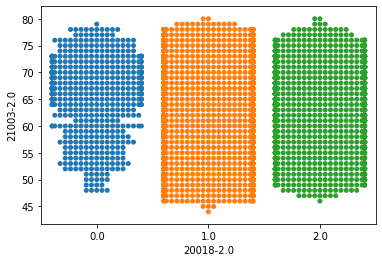

In [20]:
sns.swarmplot(x='20018-2.0', y='21003-2.0', data=phenotype_train)

**Mental health problems ever diagnosed by a professional**

Shows the first problem in the list.

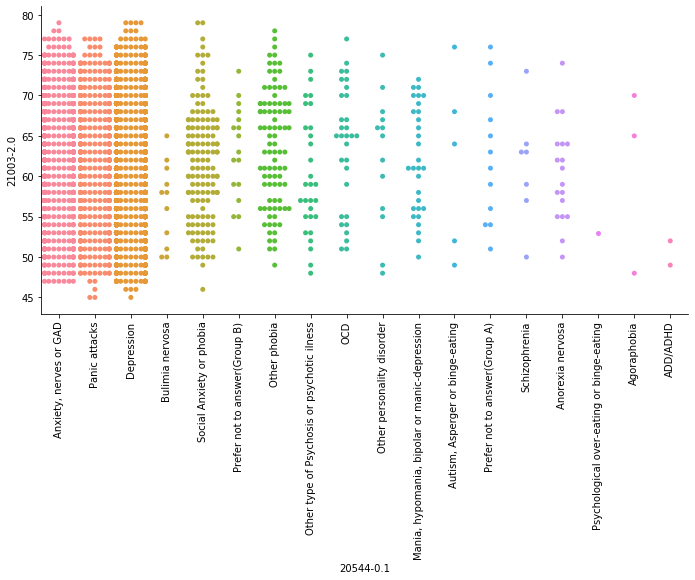

In [21]:
p1 = sns.catplot(x='20544-0.1', y='21003-2.0', data=phenotype_train, kind="swarm", aspect=2)
p1.set_xticklabels(rotation=90)

In [22]:
phenotype[phenotype['21003-2.0'] > 45]

,Unnamed: 0,31-0.0,34-0.0,50-0.0,50-1.0,50-2.0,52-0.0,54-0.0,54-1.0,54-2.0,...,40006-23.0,40006-24.0,40006-25.0,40006-26.0,40006-27.0,40006-28.0,40006-29.0,40006-30.0,40006-31.0,eid
UKB1000028,1,Female,1958,170.0,169.0,170.0,9,11010,11024.0,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000028
UKB1000133,2,Male,1947,176.0,NaN,175.0,4,11010,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000133
UKB1000260,3,Female,1949,169.0,NaN,168.0,12,11004,NaN,11027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000260
UKB1000329,4,Female,1949,158.0,NaN,158.0,2,10003,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000329
UKB1000430,5,Female,1953,158.0,NaN,158.0,7,11009,NaN,11027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKB6025704,19887,Male,1954,180.0,180.0,180.0,7,11016,11024.0,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025704
UKB6025720,19888,Female,1958,165.0,NaN,165.0,12,11014,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025720
UKB6025771,19889,Female,1953,170.0,NaN,170.0,1,11013,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025771
UKB6025805,19890,Female,1951,165.0,NaN,164.0,12,11016,NaN,11025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025805


In [23]:
phenotype_train.describe()

,Unnamed: 0,34-0.0,50-0.0,50-1.0,50-2.0,52-0.0,54-0.0,54-1.0,54-2.0,84-0.0,...,40006-23.0,40006-24.0,40006-25.0,40006-26.0,40006-27.0,40006-28.0,40006-29.0,40006-30.0,40006-31.0,eid
count,16106.000000,16106.000000,16089.000000,3962.000000,15735.000000,16106.000000,16106.000000,3965.0,16106.000000,984.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.610600e+04
mean,9933.743139,1953.171551,169.525533,169.347325,169.096740,6.415746,10993.529244,11024.0,11025.308581,1690.013211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.508174e+06
std,5723.313907,7.489937,9.115889,9.084108,9.177983,3.411744,132.340448,0.0,0.722476,714.723850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.447942e+06
min,1.000000,1936.000000,141.000000,142.000000,141.000000,1.000000,10003.000000,11024.0,11025.000000,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000028e+06
25%,5001.250000,1947.000000,163.000000,162.000000,162.000000,3.000000,11008.000000,11024.0,11025.000000,1989.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.253654e+06
50%,9921.500000,1953.000000,169.000000,169.000000,169.000000,6.000000,11010.000000,11024.0,11025.000000,2000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.512614e+06
75%,14905.500000,1959.000000,176.000000,176.000000,176.000000,9.000000,11014.000000,11024.0,11025.000000,2005.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760182e+06
max,19885.000000,1970.000000,203.000000,202.000000,203.000000,12.000000,11023.000000,11024.0,11027.000000,2010.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.025107e+06


In [24]:
phenotype.describe()

,Unnamed: 0,34-0.0,50-0.0,50-1.0,50-2.0,52-0.0,54-0.0,54-1.0,54-2.0,84-0.0,...,40006-23.0,40006-24.0,40006-25.0,40006-26.0,40006-27.0,40006-28.0,40006-29.0,40006-30.0,40006-31.0,eid
count,19891.000000,19891.000000,19869.000000,4868.000000,19439.000000,19891.000000,19891.000000,4871.0,19891.000000,1211.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.989100e+04
mean,9946.000000,1953.183249,169.548513,169.294659,169.132831,6.402896,10994.391836,11024.0,11025.306370,1685.210570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.511253e+06
std,5742.181438,7.483023,9.156549,9.110047,9.220570,3.416292,129.077233,0.0,0.720349,719.126974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.452729e+06
min,1.000000,1936.000000,141.000000,142.000000,141.000000,1.000000,10003.000000,11024.0,11025.000000,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000028e+06
25%,4973.500000,1947.000000,163.000000,162.000000,162.000000,3.000000,11008.000000,11024.0,11025.000000,1989.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.247325e+06
50%,9946.000000,1953.000000,169.000000,169.000000,169.000000,6.000000,11010.000000,11024.0,11025.000000,2000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.518224e+06
75%,14918.500000,1959.000000,176.000000,176.000000,176.000000,9.000000,11014.000000,11024.0,11025.000000,2005.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.763230e+06
max,19891.000000,1970.000000,203.000000,202.000000,203.000000,12.000000,11023.000000,11024.0,11027.000000,2010.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.025942e+06


In [103]:
labels = phenotype_train['21003-2.0'].tolist()

In [31]:
age_counts = phenotype_train['21003-2.0'].value_counts()

In [118]:
age_counts

67    826
68    788
66    785
69    771
65    752
64    720
70    707
61    690
62    665
63    647
60    603
59    584
71    578
58    550
57    527
55    524
56    518
53    500
72    484
52    480
54    479
73    467
51    434
50    396
74    324
49    292
75    269
48    215
76    206
77    103
47    101
78     69
46     23
79     21
80      4
45      3
44      1
Name: 21003-2.0, dtype: int64

In [32]:
ages = age_counts.iloc[np.argwhere(age_counts >= 3).flatten()].index.tolist()
ages

[67,
 68,
 66,
 69,
 65,
 64,
 70,
 61,
 62,
 63,
 60,
 59,
 71,
 58,
 57,
 55,
 56,
 53,
 72,
 52,
 54,
 73,
 51,
 50,
 74,
 49,
 75,
 48,
 76,
 77,
 47,
 78,
 46,
 79,
 80,
 45]

In [34]:
age_index = np.where(phenotype_train['21003-2.0'].isin(ages))[0]

In [35]:
age_index

array([    0,     1,     2, ..., 16103, 16104, 16105])

In [152]:
idx = np.where(phenotype_train['21003-2.0'].isin(ages))[0]

In [36]:
subject_ids = phenotype_train.iloc[age_index].index.tolist()

In [38]:
len(subject_ids)

16105

In [6]:
phenotype[['20016-0.0', '20016-1.0', '20016-2.0']]

,20016-0.0,20016-1.0,20016-2.0
UKB1000028,NaN,8.0,8.0
UKB1000133,NaN,NaN,4.0
UKB1000260,NaN,NaN,5.0
UKB1000329,NaN,NaN,8.0
UKB1000430,NaN,NaN,NaN
...,...,...,...
UKB6025704,6.0,7.0,8.0
UKB6025720,7.0,NaN,7.0
UKB6025771,NaN,NaN,7.0
UKB6025805,NaN,NaN,6.0


In [8]:
phenotype[['20016-2.0']]

,20016-2.0
UKB1000028,8.0
UKB1000133,4.0
UKB1000260,5.0
UKB1000329,8.0
UKB1000430,NaN
...,...
UKB6025704,8.0
UKB6025720,7.0
UKB6025771,7.0
UKB6025805,6.0


In [35]:
bipolar = phenotype[['20016-0.0', '20016-1.0', '20016-2.0']].to_numpy()

array([[nan,  8.,  8.],
       [nan, nan,  4.],
       [nan, nan,  5.],
       ...,
       [nan, nan,  7.],
       [nan, nan,  6.],
       [nan,  6.,  7.]])

In [37]:
fis = [bipolar[i, 2] or bipolar[i, 1] or bipolar[i, 0] for i in range(len(bipolar))]

In [46]:
fis_series = pd.Series(fis)
fis_series

0        8.0
1        4.0
2        5.0
3        8.0
4        NaN
        ... 
19886    8.0
19887    7.0
19888    7.0
19889    6.0
19890    7.0
Length: 19891, dtype: float64

7.0     3467
8.0     3035
6.0     3011
5.0     2529
4.0     1588
9.0     1549
10.0    1094
3.0      660
11.0     500
2.0      210
12.0     175
1.0       41
13.0      30
dtype: int64

In [50]:
phenotype[['20544-0.' + str(i) for i in range(1, 17)]]

,20544-0.1,20544-0.2,20544-0.3,20544-0.4,20544-0.5,20544-0.6,20544-0.7,20544-0.8,20544-0.9,20544-0.10,20544-0.11,20544-0.12,20544-0.13,20544-0.14,20544-0.15,20544-0.16
UKB1000028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1000133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1000260,Panic attacks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1000329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1000430,Depression,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKB6025704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6025720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6025771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6025805,"Anxiety, nerves or GAD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
mental_health = phenotype[phenotype['20544-0.1'].notnull()][['20544-0.' + str(i) for i in range(1, 17)]]

In [62]:
mental_health.describe()

,20544-0.2,20544-0.3,20544-0.4,20544-0.5,20544-0.6,20544-0.7,20544-0.8,20544-0.9,20544-0.10,20544-0.11,20544-0.12,20544-0.13,20544-0.14,20544-0.15,20544-0.16
count,1490.000000,453.000000,130.000000,38.000000,12.000000,6.000000,3.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,10.042953,13.640177,14.330769,14.315789,14.250000,14.000000,14.000000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
std,48.154436,2.341596,2.016938,2.682327,3.250874,3.741657,3.605551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-818.000000,3.000000,4.000000,5.000000,6.000000,7.000000,10.000000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
25%,11.000000,11.000000,15.000000,13.000000,13.000000,13.500000,12.500000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
50%,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
75%,15.000000,15.000000,15.000000,16.000000,16.250000,16.500000,16.000000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
max,18.000000,18.000000,17.000000,17.000000,18.000000,17.000000,17.000000,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0


In [64]:
mental_health

,20544-0.1,20544-0.2,20544-0.3,20544-0.4,20544-0.5,20544-0.6,20544-0.7,20544-0.8,20544-0.9,20544-0.10,20544-0.11,20544-0.12,20544-0.13,20544-0.14,20544-0.15,20544-0.16
UKB1000260,Panic attacks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1000430,Depression,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1001269,"Anxiety, nerves or GAD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1002158,Depression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB1002352,Panic attacks,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKB6018825,"Anxiety, nerves or GAD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6021644,"Mania, hypomania, bipolar or manic-depression",11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6022452,"Anxiety, nerves or GAD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UKB6024859,"Anxiety, nerves or GAD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
subject_i = 'UKB6022452'
subject_j = 'UKB6024859'
mental_health.loc[subject_i, '20544-0.1'] == mental_health.loc[subject_j, '20544-0.1']

True

In [69]:
subject_i = 'UKB6021644'
subject_j = 'UKB6024859'
mental_health.loc[subject_i, '20544-0.1'] == mental_health.loc[subject_j, '20544-0.1']

False

In [73]:
subject_i = 'UKB1002158'
subject_j = 'UKB6025805'
mental_health.loc[subject_i, '20544-0.1'] == mental_health.loc[subject_j, '20544-0.1']

False

In [74]:
fluid_intelligence = phenotype[['20016-0.0', '20016-1.0', '20016-2.0']]

In [76]:
fluid_intelligence[fluid_intelligence['20016-2.0'].isnull()]

,20016-0.0,20016-1.0,20016-2.0
UKB1000430,NaN,NaN,NaN
UKB1001269,NaN,NaN,NaN
UKB1003518,NaN,NaN,NaN
UKB1007166,7.0,NaN,NaN
UKB1008180,NaN,7.0,NaN
...,...,...,...
UKB6015402,NaN,NaN,NaN
UKB6015441,5.0,5.0,NaN
UKB6016745,NaN,NaN,NaN
UKB6018196,NaN,NaN,NaN


In [80]:
from math import isnan

*Test cases for fluid intelligence and other instance based phe*

In [82]:
feature = ['20016-0.0', '20016-1.0', '20016-2.0']
subject_i = 'UKB1007166'
subject_j = 'UKB1008180'
instance_i = feature[0]
for f in reversed(feature):
    if not isnan(fluid_intelligence.loc[subject_i, f]):
        instance_i = f
        break
instance_j = feature[0]
for f in reversed(feature):
    if not isnan(fluid_intelligence.loc[subject_j, f]):
        instance_j = f
        break
print(fluid_intelligence.loc[subject_i, instance_i], fluid_intelligence.loc[subject_j, instance_j])
int(fluid_intelligence.loc[subject_i, instance_i] == fluid_intelligence.loc[subject_j, instance_j])

7.0 7.0


1

In [ ]:
feature = ['20016-0.0', '20016-1.0', '20016-2.0']
subject_i = 'UKB1007166'
subject_j = 'UKB1008180'
instance_i = feature[0]
for f in reversed(feature):
    if not isnan(fluid_intelligence.loc[subject_i, f]):
        instance_i = f
        break
instance_j = feature[0]
for f in reversed(feature):
    if not isnan(fluid_intelligence.loc[subject_j, f]):
        instance_j = f
        break
print(fluid_intelligence.loc[subject_i, instance_i], fluid_intelligence.loc[subject_j, instance_j])
int(fluid_intelligence.loc[subject_i, instance_i] == fluid_intelligence.loc[subject_j, instance_j])